<a href="https://colab.research.google.com/github/Pathway2008/Weblog/blob/main/col_choice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
train = pd.read_csv('/content/drive/MyDrive/Weblog/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Weblog/test.csv')
sub = pd.read_csv('/content/drive/MyDrive/Weblog/sample_submission.csv')

In [3]:
train.drop(['sessionID','userID'],axis=1,inplace=True)
test.drop(['sessionID','userID'],axis=1,inplace=True)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252289 entries, 0 to 252288
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   TARGET               252289 non-null  float64
 1   browser              252289 non-null  object 
 2   OS                   252289 non-null  object 
 3   device               252289 non-null  object 
 4   new                  252289 non-null  int64  
 5   quality              252289 non-null  float64
 6   duration             252289 non-null  float64
 7   bounced              252289 non-null  int64  
 8   transaction          252289 non-null  float64
 9   transaction_revenue  252289 non-null  float64
 10  continent            252289 non-null  object 
 11  subcontinent         252289 non-null  object 
 12  country              252289 non-null  object 
 13  traffic_source       252289 non-null  object 
 14  traffic_medium       252289 non-null  object 
 15  keyword          

In [7]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
object_columns = train.drop(columns=['TARGET']).select_dtypes(include='object')
for feature in object_columns.columns:
    le = LabelEncoder()

    # Convert the column to string type
    train[feature] = train[feature].astype(str)
    le.fit(train[feature])
    train[feature] = le.transform(train[feature])

    # Make sure the test set has the same data type
    test[feature] = test[feature].astype(str)

    # Handle unseen labels in the test set
    for label in np.unique(test[feature]):
        if label not in le.classes_:
            le.classes_ = np.append(le.classes_, label)

    test[feature] = le.transform(test[feature])

In [8]:
train.head()

,TARGET,browser,OS,device,new,quality,duration,bounced,transaction,transaction_revenue,continent,subcontinent,country,traffic_source,traffic_medium,keyword,referral_path
0,17.0,27,7,0,0,45.0,839.0,0,0.0,0.0,2,12,196,46,5,621,1578
1,3.0,27,17,0,1,1.0,39.0,0,0.0,0.0,4,22,67,46,5,621,1578
2,1.0,51,1,1,1,1.0,0.0,1,0.0,0.0,3,16,115,0,0,623,1578
3,1.0,27,7,0,1,1.0,0.0,1,0.0,0.0,2,12,196,1,2,623,1578
4,1.0,27,20,1,0,1.0,0.0,1,0.0,0.0,2,12,196,87,6,623,1180


In [9]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 2.5 MB/s eta 0:00:00


In [10]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
import xgboost as xgb
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from math import sqrt
from sklearn.metrics import make_scorer, mean_squared_error

In [224]:
from sklearn.model_selection import KFold
kf = StratifiedKFold(n_splits=5, shuffle=False)

In [233]:
from sklearn.model_selection import train_test_split
X = train.drop(['TARGET', 'device', 'traffic_medium', 'keyword','referral_path'], axis=1)
y = train['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 43)

In [234]:
def rmse_scorer(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

# Random Forest
rf_model = RandomForestRegressor(random_state=43)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_scores = cross_val_score(rf_model, X_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))
rf_rmse = rmse_scorer(y_test, rf_predictions)


# Extra Trees
et_model = ExtraTreesRegressor(random_state=43)
et_model.fit(X_train, y_train)
et_predictions = et_model.predict(X_test)
et_scores = cross_val_score(et_model, X_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))
et_rmse = rmse_scorer(y_test, et_predictions)

#xgb
xgb_model = xgb.XGBRegressor(random_state=43, reg_lambda=4)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)
xgb_scores = cross_val_score(xgb_model, X_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))
xgb_rmse = rmse_scorer(y_test, xgb_predictions)

#cat
cat_model = CatBoostRegressor(random_seed=43)
cat_model.fit(X_train, y_train)
cat_predictions = cat_model.predict(X_test)
cat_scores = cross_val_score(cat_model, X_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))
cat_rmse = rmse_scorer(y_test, cat_predictions)

#lgb
lgb_model = LGBMRegressor(random_state=42)
lgb_model.fit(X_train, y_train)
lgb_predictions = lgb_model.predict(X_test)
lgb_scores = cross_val_score(lgb_model, X_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))
lgb_rmse = rmse_scorer(y_test, lgb_predictions)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
40:	learn: 2.9403932	total: 561ms	remaining: 13.1s
41:	learn: 2.9399749	total: 571ms	remaining: 13s
42:	learn: 2.9386440	total: 581ms	remaining: 12.9s
43:	learn: 2.9357658	total: 594ms	remaining: 12.9s
44:	learn: 2.9354000	total: 603ms	remaining: 12.8s
45:	learn: 2.9328963	total: 617ms	remaining: 12.8s
46:	learn: 2.9319811	total: 628ms	remaining: 12.7s
47:	learn: 2.9275249	total: 643ms	remaining: 12.8s
48:	learn: 2.9244216	total: 657ms	remaining: 12.7s
49:	learn: 2.9220443	total: 670ms	remaining: 12.7s
50:	learn: 2.9166818	total: 684ms	remaining: 12.7s
51:	learn: 2.9135463	total: 695ms	remaining: 12.7s
52:	learn: 2.9118144	total: 706ms	remaining: 12.6s
53:	learn: 2.9109935	total: 718ms	remaining: 12.6s
54:	learn: 2.9052673	total: 731ms	remaining: 12.6s
55:	learn: 2.9036971	total: 745ms	remaining: 12.6s
56:	learn: 2.9031090	total: 754ms	remaining: 12.5s
57:	learn: 2.9002287	total: 768ms	remaining: 12.5s
58:	learn: 2.8989955	total: 780ms	remaining: 12.

In [227]:
#drop 'device', 'traffic_medium', 'keyword'
print(f'Random Forest Cross-Validation RMSE: {rf_scores.mean()}')
print(f'RF test RMSE: {rf_rmse}\n')
print(f'Extra Trees Cross-Validation RMSE: {et_scores.mean()}')
print(f'ET test RMSE: {et_rmse}\n')
print(f'XGBoost Cross-Validation RMSE: {xgb_scores.mean()}')
print(f'XGBoost test RMSE: {xgb_rmse}\n')
print(f'CatBoost Cross-Validation RMSE: {cat_scores.mean()}')
print(f'CatBoost test RMSE: {cat_rmse}\n')
print(f"Cross-validated LightGBM scores: {lgb_scores.mean()}")
print(f"LightGBM RMSE on test set: {lgb_rmse}")

Random Forest Cross-Validation RMSE: 2.8670504774502477
RF test RMSE: 2.812503055608758

Extra Trees Cross-Validation RMSE: 2.9281515668953237
ET test RMSE: 2.921826705209167

XGBoost Cross-Validation RMSE: 2.8687832089766863
XGBoost test RMSE: 2.773079692905336

CatBoost Cross-Validation RMSE: 2.78221477769186
CatBoost test RMSE: 2.739800047325843

Cross-validated LightGBM scores: 2.7508833194612734
LightGBM RMSE on test set: 2.7696597546554442


In [235]:
#drop 'device', 'traffic_medium', 'keyword', 'referral_path'
print(f'Random Forest Cross-Validation RMSE: {rf_scores.mean()}')
print(f'RF test RMSE: {rf_rmse}\n')
print(f'Extra Trees Cross-Validation RMSE: {et_scores.mean()}')
print(f'ET test RMSE: {et_rmse}\n')
print(f'XGBoost Cross-Validation RMSE: {xgb_scores.mean()}')
print(f'XGBoost test RMSE: {xgb_rmse}\n')
print(f'CatBoost Cross-Validation RMSE: {cat_scores.mean()}')
print(f'CatBoost test RMSE: {cat_rmse}\n')
print(f"Cross-validated LightGBM scores: {lgb_scores.mean()}")
print(f"LightGBM RMSE on test set: {lgb_rmse}")

Random Forest Cross-Validation RMSE: 2.888546856490687
RF test RMSE: 2.8345734171525097

Extra Trees Cross-Validation RMSE: 2.960956124820126
ET test RMSE: 2.954929435190673

XGBoost Cross-Validation RMSE: 2.915207798092001
XGBoost test RMSE: 2.790346771466248

CatBoost Cross-Validation RMSE: 2.8049006855244967
CatBoost test RMSE: 2.7727558591685315

Cross-validated LightGBM scores: 2.755338932360212
LightGBM RMSE on test set: 2.7871987327330787


In [240]:
from sklearn.ensemble import VotingRegressor
voting_regressor = VotingRegressor([('xgb', xgb_model), ('catboost', cat_model), ('et',et_model),('rf',rf_model),('lgb',lgb_model)])#cat_model로 수정필요
voting_regressor.fit(X_train, y_train)

voting_predictions = voting_regressor.predict(X_test)

voting_rmse = rmse_scorer(y_test, voting_predictions)
voting_scores = cross_val_score(voting_regressor, X_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
34:	learn: 2.9770499	total: 473ms	remaining: 13s
35:	learn: 2.9698950	total: 486ms	remaining: 13s
36:	learn: 2.9644101	total: 499ms	remaining: 13s
37:	learn: 2.9603248	total: 509ms	remaining: 12.9s
38:	learn: 2.9511411	total: 521ms	remaining: 12.8s
39:	learn: 2.9455418	total: 535ms	remaining: 12.8s
40:	learn: 2.9403932	total: 547ms	remaining: 12.8s
41:	learn: 2.9399749	total: 555ms	remaining: 12.7s
42:	learn: 2.9386440	total: 565ms	remaining: 12.6s
43:	learn: 2.9357658	total: 577ms	remaining: 12.5s
44:	learn: 2.9354000	total: 585ms	remaining: 12.4s
45:	learn: 2.9328963	total: 596ms	remaining: 12.4s
46:	learn: 2.9319811	total: 609ms	remaining: 12.4s
47:	learn: 2.9275249	total: 622ms	remaining: 12.3s
48:	learn: 2.9244216	total: 635ms	remaining: 12.3s
49:	learn: 2.9220443	total: 646ms	remaining: 12.3s
50:	learn: 2.9166818	total: 659ms	remaining: 12.3s
51:	learn: 2.9135463	total: 670ms	remaining: 12.2s
52:	learn: 2.9118144	total: 683ms	remaining: 12.2s
5

In [229]:
#drop 'device', 'traffic_medium', 'keyword'
print(f'VotingRegressor Cross-Validation RMSE: {voting_scores.mean()}')
print(f'VotingRegressor test RMSE: {voting_rmse}')

VotingRegressor Cross-Validation RMSE: 2.729610973422365
VotingRegressor test RMSE: 2.7023693926691226


In [241]:
# drop 'device', 'traffic_medium', 'keyword', 'referral_path'
print(f'VotingRegressor Cross-Validation RMSE: {voting_scores.mean()}')
print(f'VotingRegressor test RMSE: {voting_rmse}')

VotingRegressor Cross-Validation RMSE: 2.7432350255191476
VotingRegressor test RMSE: 2.7214084604136666


In [239]:
# drop 'device', 'traffic_medium', 'keyword', 'referral_path' + xgb,lgb,cat
print(f'VotingRegressor Cross-Validation RMSE: {voting_scores.mean()}')
print(f'VotingRegressor test RMSE: {voting_rmse}')

VotingRegressor Cross-Validation RMSE: 2.7744915362763436
VotingRegressor test RMSE: 2.748829725960754


In [242]:
voting_predictions = voting_regressor.predict(test.drop(['device', 'traffic_medium', 'keyword','referral_path'],axis=1))
sub['TARGET'] = voting_predictions
sub.to_csv('drop(dev,medi,key,path)_xgb+cat+lgb+rf+et.csv',index=False)

#XGB

In [80]:
import warnings
import matplotlib.font_manager as fm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
warnings.filterwarnings('ignore')
!apt-get -qq install fonts-nanum


fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
    name='NanumGothic')
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'})

Selecting previously unselected package fonts-nanum.
(Reading database ... 121749 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [15]:
def rmse_scorer(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

In [86]:
from sklearn.model_selection import train_test_split
X = train.drop(['TARGET','keyword','referral_path','transaction_revenue','traffic_medium'], axis=1)
y = train['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 43)

In [87]:
xgb_model = xgb.XGBRegressor(random_state=43,reg_lambda=4)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)
xgb_scores = cross_val_score(xgb_model, X_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))
xgb_rmse = rmse_scorer(y_test, xgb_predictions)

In [22]:
#base
print(f'XGBoost Cross-Validation RMSE: {xgb_scores.mean()}')
print(f'XGBoost test RMSE: {xgb_rmse}\n')

XGBoost Cross-Validation RMSE: 2.92094598586404
XGBoost test RMSE: 2.7695829562625494



In [32]:
#reg_lambda=0.5, alpha=0
print(f'XGBoost Cross-Validation RMSE: {xgb_scores.mean()}')
print(f'XGBoost test RMSE: {xgb_rmse}\n')

XGBoost Cross-Validation RMSE: 2.9530281245184207
XGBoost test RMSE: 2.7453044727720295



In [44]:
#reg_lambda=3
print(f'XGBoost Cross-Validation RMSE: {xgb_scores.mean()}')
print(f'XGBoost test RMSE: {xgb_rmse}\n')

XGBoost Cross-Validation RMSE: 2.872509962360305
XGBoost test RMSE: 2.805546828508527



In [56]:
#reg_lambda=4 , drop('keyword''referral_path')
print(f'XGBoost Cross-Validation RMSE: {xgb_scores.mean()}')
print(f'XGBoost test RMSE: {xgb_rmse}\n')

XGBoost Cross-Validation RMSE: 2.870929841865618
XGBoost test RMSE: 2.7544141791494807



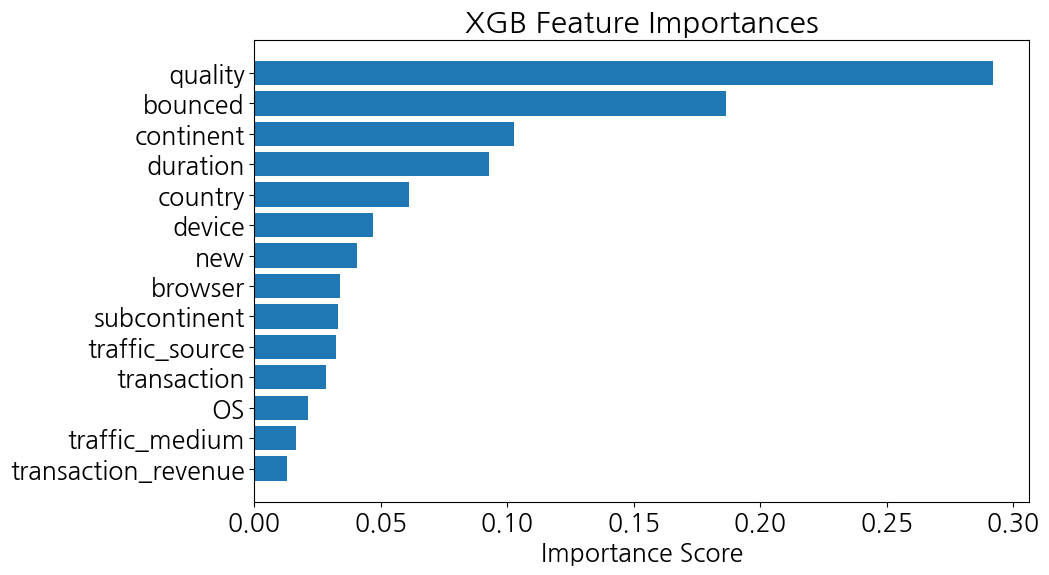

In [82]:
feature_importances = xgb_model.feature_importances_
feature_names = X_train.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance')

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance Score')
plt.title('XGB Feature Importances')
plt.show()

In [85]:
#reg_lambda=4 , drop('keyword''referral_path')
print(f'XGBoost Cross-Validation RMSE: {xgb_scores.mean()}')
print(f'XGBoost test RMSE: {xgb_rmse}\n')

XGBoost Cross-Validation RMSE: 2.903112638106003
XGBoost test RMSE: 2.7340644198995356



In [88]:
#reg_lambda=4 , drop('keyword''referral_path')
print(f'XGBoost Cross-Validation RMSE: {xgb_scores.mean()}')
print(f'XGBoost test RMSE: {xgb_rmse}\n')

XGBoost Cross-Validation RMSE: 2.9147381840976014
XGBoost test RMSE: 2.7549351742239865



In [ ]:
#total
print(f'Random Forest Cross-Validation RMSE: {rf_scores.mean()}')
print(f'RF test RMSE: {rf_rmse}\n')
print(f'Extra Trees Cross-Validation RMSE: {et_scores.mean()}')
print(f'ET test RMSE: {et_rmse}\n')
print(f'XGBoost Cross-Validation RMSE: {xgb_scores.mean()}')
print(f'XGBoost test RMSE: {xgb_rmse}\n')
print(f'CatBoost Cross-Validation RMSE: {cat_scores.mean()}')
print(f'CatBoost test RMSE: {cat_rmse}\n')
print(f"Cross-validated LightGBM scores: {lgb_scores.mean()}")
print(f"LightGBM RMSE on test set: {lgb_rmse}")

In [117]:
feature_names = train.columns.tolist()
feature_names

['TARGET',
 'browser',
 'OS',
 'device',
 'new',
 'quality',
 'duration',
 'bounced',
 'transaction',
 'transaction_revenue',
 'continent',
 'subcontinent',
 'country',
 'traffic_source',
 'traffic_medium',
 'keyword',
 'referral_path']

In [118]:
feature_names.remove('TARGET')

In [119]:
feature_names.remove('quality')
feature_names.remove('duration')
feature_names.remove('bounced')
feature_names.remove('continent')
feature_names.remove('country')

In [170]:
feature_names,len(feature_names)

(['browser',
  'OS',
  'device',
  'new',
  'transaction',
  'transaction_revenue',
  'subcontinent',
  'traffic_source',
  'traffic_medium',
  'keyword',
  'referral_path'],
 11)

In [122]:
from sklearn.model_selection import train_test_split

for i in range(len(feature_names)):
  X = train.drop(['TARGET',feature_names[i]], axis=1)
  y = train['TARGET']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 43)

  xgb_model = xgb.XGBRegressor(random_state=43,reg_lambda=4)
  xgb_model.fit(X_train, y_train)
  xgb_predictions = xgb_model.predict(X_test)
  xgb_scores = cross_val_score(xgb_model, X_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))
  xgb_rmse = rmse_scorer(y_test, xgb_predictions)

  print(feature_names[i],xgb_scores.mean(),xgb_rmse,'\n')

browser 2.813814141212327 2.795711172639246 

OS 2.8521282839851336 2.741151180694373 

device 2.8055993104898747 2.7522648747145664 

new 2.9207325973835263 2.8713038132331743 

transaction 2.8457171596848325 2.784998364196626 

transaction_revenue 2.83874460084263 2.746092912843986 

subcontinent 2.805575796390739 2.7502915728202746 

traffic_source 2.825691419241324 2.732398960010314 

traffic_medium 2.8266154578550795 2.7807232956458465 

keyword 2.821611557493626 2.7532671888318476 

referral_path 2.834260305867851 2.7857613046609315 



In [175]:
from sklearn.model_selection import train_test_split

for i in range(len(feature_names)):
  X = train.drop(['TARGET',feature_names[i]], axis=1)
  y = train['TARGET']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 43)

  xgb_model = xgb.XGBRegressor(random_state=43)
  xgb_model.fit(X_train, y_train)
  xgb_predictions = xgb_model.predict(X_test)
  xgb_scores = cross_val_score(xgb_model, X_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))
  xgb_rmse = rmse_scorer(y_test, xgb_predictions)

  print(feature_names[i],xgb_scores.mean(),xgb_rmse,'\n')

browser 2.8707206407417876 2.8323936028040544 

OS 2.878375541985355 2.8188853723292855 

device 2.8684470805521 2.7680752507558113 

new 2.940399212957214 2.8682700809584434 

transaction 2.8658374438496557 2.776367182250705 

transaction_revenue 2.843029553150317 2.8065989976309957 

subcontinent 2.8565485659677976 2.823562717724226 

traffic_source 2.8565771558460553 2.8171167344083488 

traffic_medium 2.85081255668774 2.8256878979927857 

keyword 2.8408839261060743 2.7579802379913114 

referral_path 2.84209828849354 2.7881411981785424 



In [208]:
from sklearn.model_selection import train_test_split
col2_lamda4 = pd.DataFrame(columns=['Feature1', 'Feature2', 'mean_score', 'rmse'])

for i in range(len(feature_names)):
  for j in range(i+1,len(feature_names)):
    X = train.drop(['TARGET',feature_names[i],feature_names[j]], axis=1)
    y = train['TARGET']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 43)

    xgb_model = xgb.XGBRegressor(random_state=43,reg_lambda=4)
    xgb_model.fit(X_train, y_train)
    xgb_predictions = xgb_model.predict(X_test)
    xgb_scores = cross_val_score(xgb_model, X_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))
    xgb_rmse = rmse_scorer(y_test, xgb_predictions)

    col2_lamda4 = col2_lamda4.append({
        'Feature1': feature_names[i],
        'Feature2': feature_names[j],
        'mean_score': xgb_scores.mean(),
        'rmse': xgb_rmse
    }, ignore_index=True)

In [209]:
# col2_lamda4
min_mean_score_row = col2_lamda4.loc[col2_lamda4['mean_score'].idxmin()]
min_rmse_row = col2_lamda4.loc[col2_lamda4['rmse'].idxmin()]

print("Row with minimum MeanScore:")
print(min_mean_score_row)
print("\nRow with minimum RMSE:")
print(min_rmse_row)

Row with minimum MeanScore:
Feature1       browser
Feature2       keyword
mean_score    2.805856
rmse          2.794693
Name: 8, dtype: object

Row with minimum RMSE:
Feature1                   device
Feature2      transaction_revenue
mean_score               2.841409
rmse                     2.722942
Name: 21, dtype: object


In [189]:
from sklearn.model_selection import train_test_split
col2_base = pd.DataFrame(columns=['Feature1', 'Feature2', 'mean_score', 'rmse'])

for i in range(len(feature_names)):
  for j in range(i+1,len(feature_names)):
    X = train.drop(['TARGET',feature_names[i],feature_names[j]], axis=1)
    y = train['TARGET']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 43)

    xgb_model = xgb.XGBRegressor(random_state=43)
    xgb_model.fit(X_train, y_train)
    xgb_predictions = xgb_model.predict(X_test)
    xgb_scores = cross_val_score(xgb_model, X_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))
    xgb_rmse = rmse_scorer(y_test, xgb_predictions)

    col2_base = col2_base.append({
        'Feature1': feature_names[i],
        'Feature2': feature_names[j],
        'mean_score': xgb_scores.mean(),
        'rmse': xgb_rmse
    }, ignore_index=True)

In [191]:
# col2_base
min_mean_score_row = col2_base.loc[col2_base['mean_score'].idxmin()]
min_rmse_row = col2_base.loc[col2_base['rmse'].idxmin()]

print("Row with minimum MeanScore:")
print(min_mean_score_row)
print("\nRow with minimum RMSE:")
print(min_rmse_row)

Row with minimum MeanScore:
Feature1                   device
Feature2      transaction_revenue
mean_score               2.834274
rmse                     2.785051
Name: 21, dtype: object

Row with minimum RMSE:
Feature1              transaction
Feature2      transaction_revenue
mean_score               2.893284
rmse                     2.736038
Name: 34, dtype: object


In [210]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Assuming the necessary imports and functions are defined previously

# Initialize an empty DataFrame to store the results
result_df = pd.DataFrame(columns=['Feature1', 'Feature2', 'Feature3', 'mean_score', 'rmse'])

# Iterate over combinations of three features
for i in range(len(feature_names)):
    for j in range(i + 1, len(feature_names)):
        for w in range(j + 1, len(feature_names)):
            # Drop selected features from the DataFrame
            X = train.drop(['TARGET', feature_names[i], feature_names[j], feature_names[w]], axis=1)
            y = train['TARGET']
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43)

            # Train XGBoost model
            xgb_model = xgb.XGBRegressor(random_state=43, reg_lambda=4)
            xgb_model.fit(X_train, y_train)
            xgb_predictions = xgb_model.predict(X_test)
            xgb_scores = cross_val_score(xgb_model, X_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))
            xgb_rmse = rmse_scorer(y_test, xgb_predictions)

            # Append the results to the DataFrame
            result_df = result_df.append({
                'Feature1': feature_names[i],
                'Feature2': feature_names[j],
                'Feature3': feature_names[w],
                'mean_score': xgb_scores.mean(),
                'rmse': xgb_rmse
            }, ignore_index=True)

In [211]:
# col3_lamda4
min_mean_score_row = result_df.loc[result_df['mean_score'].idxmin()]
min_rmse_row = result_df.loc[result_df['rmse'].idxmin()]

print("Row with minimum MeanScore:")
print(min_mean_score_row)
print("\nRow with minimum RMSE:")
print(min_rmse_row)

Row with minimum MeanScore:
Feature1              device
Feature2      traffic_medium
Feature3             keyword
mean_score          2.800032
rmse                 2.77308
Name: 106, dtype: object

Row with minimum RMSE:
Feature1                   device
Feature2      transaction_revenue
Feature3           traffic_source
mean_score                2.82642
rmse                     2.716733
Name: 95, dtype: object


In [183]:
col3_base = pd.DataFrame(columns=['Feature1', 'Feature2', 'Feature3', 'mean_score', 'rmse'])

# Iterate over combinations of three features
for i in range(len(feature_names)):
    for j in range(i + 1, len(feature_names)):
        for w in range(j + 1, len(feature_names)):
            # Drop selected features from the DataFrame
            X = train.drop(['TARGET', feature_names[i], feature_names[j], feature_names[w]], axis=1)
            y = train['TARGET']
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43)

            # Train XGBoost model
            xgb_model = xgb.XGBRegressor(random_state=43)
            xgb_model.fit(X_train, y_train)
            xgb_predictions = xgb_model.predict(X_test)
            xgb_scores = cross_val_score(xgb_model, X_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))
            xgb_rmse = rmse_scorer(y_test, xgb_predictions)

            # Append the results to the DataFrame
            col3_base = col3_base.append({
                'Feature1': feature_names[i],
                'Feature2': feature_names[j],
                'Feature3': feature_names[w],
                'mean_score': xgb_scores.mean(),
                'rmse': xgb_rmse
            }, ignore_index=True)

In [188]:
# col3_base
min_mean_score_row = col3_base.loc[col3_base['mean_score'].idxmin()]
min_rmse_row = col3_base.loc[col3_base['rmse'].idxmin()]

print("Row with minimum MeanScore:")
print(min_mean_score_row)
print("\nRow with minimum RMSE:")
print(min_rmse_row)

Row with minimum MeanScore:
Feature1            device
Feature2      subcontinent
Feature3           keyword
mean_score        2.818047
rmse              2.803895
Name: 101, dtype: object

Row with minimum RMSE:
Feature1              device
Feature2         transaction
Feature3      traffic_medium
mean_score          2.877557
rmse                  2.7328
Name: 91, dtype: object


In [212]:
col4_lamda4 = pd.DataFrame(columns=['Feature1', 'Feature2', 'Feature3','Feature4','mean_score', 'rmse'])

# Iterate over combinations of three features
for i in range(len(feature_names)):
    for j in range(i + 1, len(feature_names)):
        for w in range(j + 1, len(feature_names)):
          for k in range(w + 1,len(feature_names)):
            X = train.drop(['TARGET', feature_names[i], feature_names[j], feature_names[w], feature_names[k]], axis=1)
            y = train['TARGET']
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43)

            # Train XGBoost model
            xgb_model = xgb.XGBRegressor(random_state=43,reg_lambda=4)
            xgb_model.fit(X_train, y_train)
            xgb_predictions = xgb_model.predict(X_test)
            xgb_scores = cross_val_score(xgb_model, X_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))
            xgb_rmse = rmse_scorer(y_test, xgb_predictions)

            # Append the results to the DataFrame
            col4_lamda4 = col4_lamda4.append({
                'Feature1': feature_names[i],
                'Feature2': feature_names[j],
                'Feature3': feature_names[w],
                'Feature4': feature_names[k],
                'mean_score': xgb_scores.mean(),
                'rmse': xgb_rmse
            }, ignore_index=True)

In [213]:
# col4_lamda4
min_mean_score_row = col4_lamda4.loc[col4_lamda4['mean_score'].idxmin()]
min_rmse_row = col4_lamda4.loc[col4_lamda4['rmse'].idxmin()]

print("Row with minimum MeanScore:")
print(min_mean_score_row)
print("\nRow with minimum RMSE:")
print(min_rmse_row)

Row with minimum MeanScore:
Feature1             browser
Feature2              device
Feature3      traffic_medium
Feature4             keyword
mean_score          2.807741
rmse                2.790035
Name: 61, dtype: object

Row with minimum RMSE:
Feature1      transaction_revenue
Feature2             subcontinent
Feature3                  keyword
Feature4            referral_path
mean_score                2.85568
rmse                     2.724973
Name: 320, dtype: object


In [206]:
col4_base = pd.DataFrame(columns=['Feature1', 'Feature2', 'Feature3','Feature4','mean_score', 'rmse'])

# Iterate over combinations of three features
for i in range(len(feature_names)):
    for j in range(i + 1, len(feature_names)):
        for w in range(j + 1, len(feature_names)):
          for k in range(w + 1,len(feature_names)):
            X = train.drop(['TARGET', feature_names[i], feature_names[j], feature_names[w], feature_names[k]], axis=1)
            y = train['TARGET']
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43)

            # Train XGBoost model
            xgb_model = xgb.XGBRegressor(random_state=43)
            xgb_model.fit(X_train, y_train)
            xgb_predictions = xgb_model.predict(X_test)
            xgb_scores = cross_val_score(xgb_model, X_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))
            xgb_rmse = rmse_scorer(y_test, xgb_predictions)

            # Append the results to the DataFrame
            col4_base = col4_base.append({
                'Feature1': feature_names[i],
                'Feature2': feature_names[j],
                'Feature3': feature_names[w],
                'Feature4': feature_names[k],
                'mean_score': xgb_scores.mean(),
                'rmse': xgb_rmse
            }, ignore_index=True)

In [207]:
# col4_base
min_mean_score_row = col4_base.loc[col4_base['mean_score'].idxmin()]
min_rmse_row = col4_base.loc[col4_base['rmse'].idxmin()]

print("Row with minimum MeanScore:")
print(min_mean_score_row)
print("\nRow with minimum RMSE:")
print(min_rmse_row)

Row with minimum MeanScore:
Feature1             browser
Feature2              device
Feature3      traffic_medium
Feature4       referral_path
mean_score          2.836589
rmse                2.839678
Name: 62, dtype: object

Row with minimum RMSE:
Feature1                       OS
Feature2              transaction
Feature3      transaction_revenue
Feature4           traffic_medium
mean_score                2.89848
rmse                     2.738303
Name: 171, dtype: object


In [216]:
col5_lamda4 = pd.DataFrame(columns=['Feature1', 'Feature2', 'Feature3','Feature4','Feature5','mean_score', 'rmse'])

# Iterate over combinations of three features
for i in range(len(feature_names)):
    for j in range(i + 1, len(feature_names)):
        for w in range(j + 1, len(feature_names)):
          for k in range(w + 1,len(feature_names)):
            for z in range(k + 1,len(feature_names)):
              X = train.drop(['TARGET', feature_names[i], feature_names[j], feature_names[w], feature_names[k], feature_names[z]], axis=1)
              y = train['TARGET']
              X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43)

              # Train XGBoost model
              xgb_model = xgb.XGBRegressor(random_state=43,reg_lambda=4)
              xgb_model.fit(X_train, y_train)
              xgb_predictions = xgb_model.predict(X_test)
              xgb_scores = cross_val_score(xgb_model, X_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))
              xgb_rmse = rmse_scorer(y_test, xgb_predictions)

              # Append the results to the DataFrame
              col5_lamda4 = col5_lamda4.append({
                  'Feature1': feature_names[i],
                  'Feature2': feature_names[j],
                  'Feature3': feature_names[w],
                  'Feature4': feature_names[k],
                  'Feature5': feature_names[z],
                  'mean_score': xgb_scores.mean(),
                  'rmse': xgb_rmse
              }, ignore_index=True)

In [217]:
# col5_lamda4
min_mean_score_row = col5_lamda4.loc[col5_lamda4['mean_score'].idxmin()]
min_rmse_row = col5_lamda4.loc[col5_lamda4['rmse'].idxmin()]

print("Row with minimum MeanScore:")
print(min_mean_score_row)
print("\nRow with minimum RMSE:")
print(min_rmse_row)

Row with minimum MeanScore:
Feature1                  browser
Feature2                   device
Feature3      transaction_revenue
Feature4           traffic_medium
Feature5                  keyword
mean_score                2.80923
rmse                     2.781704
Name: 127, dtype: object

Row with minimum RMSE:
Feature1                   device
Feature2      transaction_revenue
Feature3             subcontinent
Feature4           traffic_medium
Feature5            referral_path
mean_score                2.82943
rmse                     2.720146
Name: 395, dtype: object


In [218]:
col5_base = pd.DataFrame(columns=['Feature1', 'Feature2', 'Feature3','Feature4','Feature5','mean_score', 'rmse'])

# Iterate over combinations of three features
for i in range(len(feature_names)):
    for j in range(i + 1, len(feature_names)):
        for w in range(j + 1, len(feature_names)):
          for k in range(w + 1,len(feature_names)):
            for z in range(k + 1,len(feature_names)):
              X = train.drop(['TARGET', feature_names[i], feature_names[j], feature_names[w], feature_names[k], feature_names[z]], axis=1)
              y = train['TARGET']
              X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43)

              # Train XGBoost model
              xgb_model = xgb.XGBRegressor(random_state=43)
              xgb_model.fit(X_train, y_train)
              xgb_predictions = xgb_model.predict(X_test)
              xgb_scores = cross_val_score(xgb_model, X_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))
              xgb_rmse = rmse_scorer(y_test, xgb_predictions)

              # Append the results to the DataFrame
              col5_base = col5_base.append({
                  'Feature1': feature_names[i],
                  'Feature2': feature_names[j],
                  'Feature3': feature_names[w],
                  'Feature4': feature_names[k],
                  'Feature5': feature_names[z],
                  'mean_score': xgb_scores.mean(),
                  'rmse': xgb_rmse
              }, ignore_index=True)

In [219]:
# col5_base
min_mean_score_row = col5_base.loc[col5_base['mean_score'].idxmin()]
min_rmse_row = col5_base.loc[col5_base['rmse'].idxmin()]

print("Row with minimum MeanScore:")
print(min_mean_score_row)
print("\nRow with minimum RMSE:")
print(min_rmse_row)

Row with minimum MeanScore:
Feature1              device
Feature2         transaction
Feature3        subcontinent
Feature4      traffic_medium
Feature5             keyword
mean_score          2.834275
rmse                2.792431
Name: 384, dtype: object

Row with minimum RMSE:
Feature1         transaction
Feature2        subcontinent
Feature3      traffic_medium
Feature4             keyword
Feature5       referral_path
mean_score          2.873728
rmse                2.757477
Name: 454, dtype: object


In [ ]:
'''
col1_lam
subcontinent 2.805575796390739 2.7502915728202746
traffic_source 2.825691419241324 2.732398960010314

col1_base
keyword 2.8408839261060743 2.7579802379913114

col2_lam
browser, keyword 2.805856 2.794693
device, transaction_revenue 2.841409, 2.722942

col2_base
device,transaction_revenue  2.834274 2.785051
transaction, transaction_revenue 2.893284 2.736038

col3_lam
device, traffic_medium, keyword 2.800032 2.77308  ***
device,transaction_revenue, traffic_source 2.82642 2.716733 ***

col3_base
device, subcontinent, keyword 2.818047 2.803895
device, transaction, traffic_medium 2.877557, 2.7328

col4_lam
browser, device, traffic_medium, keyword 2.807741  2.790035
transaction_revenue, subcontinent, keyword, referral_path 2.85568, 2.724973

col4_base
browser, device, traffic_medium, referral_path 2.836589 2.839678
OS, transaction, transaction_revenue, traffic_medium 2.89848 2.738303

col5_lam
browser, device, transaction_revenue, traffic_medium, keyword 2.80923 2.781704
device, transaction_revenue, subcontinent, traffic_medium, referral_path 2.82943 2.720146

col5_base
device, transaction, subcontinent, traffic_medium, keyword 2.834275 2.792431
transaction, subcontinent, traffic_medium, keyword, referral_path 2.873728, 2.757477
'''

#cat

In [ ]:
catcol3_lam4 = pd.DataFrame(columns=['Feature1', 'Feature2', 'Feature3', 'mean_score', 'rmse'])

# Iterate over combinations of three features
for i in range(len(feature_names)):
    for j in range(i + 1, len(feature_names)):
        for w in range(j + 1, len(feature_names)):
            # Drop selected features from the DataFrame
            X = train.drop(['TARGET', feature_names[i], feature_names[j], feature_names[w]], axis=1)
            y = train['TARGET']
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43)

            cat_model = CatBoostRegressor(random_seed=43, reg_lambda=4)
            cat_model.fit(X_train, y_train)
            cat_predictions = cat_model.predict(X_test)
            cat_scores = cross_val_score(cat_model, X_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))
            cat_rmse = rmse_scorer(y_test, cat_predictions)

            # Append the results to the DataFrame
            catcol3_lam4 = catcol3_lam4.append({
                'Feature1': feature_names[i],
                'Feature2': feature_names[j],
                'Feature3': feature_names[w],
                'mean_score': cat_scores.mean(),
                'rmse': cat_rmse
            }, ignore_index=True)

In [221]:
# catcol3_lam4
min_mean_score_row = catcol3_lam4.loc[catcol3_lam4['mean_score'].idxmin()]
min_rmse_row = catcol3_lam4.loc[catcol3_lam4['rmse'].idxmin()]

print("Row with minimum MeanScore:")
print(min_mean_score_row)
print("\nRow with minimum RMSE:")
print(min_rmse_row)

Row with minimum MeanScore:
Feature1       browser
Feature2            OS
Feature3        device
mean_score    2.957061
rmse          2.896025
Name: 0, dtype: object

Row with minimum RMSE:
Feature1       browser
Feature2            OS
Feature3        device
mean_score    2.957061
rmse          2.896025
Name: 0, dtype: object


#ET

In [ ]:
etcol3_base = pd.DataFrame(columns=['Feature1', 'Feature2', 'Feature3', 'mean_score', 'rmse'])

# Iterate over combinations of three features
for i in range(len(feature_names)):
    for j in range(i + 1, len(feature_names)):
        for w in range(j + 1, len(feature_names)):
            # Drop selected features from the DataFrame
            X = train.drop(['TARGET', feature_names[i], feature_names[j], feature_names[w]], axis=1)
            y = train['TARGET']
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43)

            et_model = ExtraTreesRegressor(random_state=43)
            et_model.fit(X_train, y_train)
            et_predictions = et_model.predict(X_test)
            et_scores = cross_val_score(et_model, X_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))
            et_rmse = rmse_scorer(y_test, et_predictions)

            # Append the results to the DataFrame
            etcol3_base = etcol3_base.append({
                'Feature1': feature_names[i],
                'Feature2': feature_names[j],
                'Feature3': feature_names[w],
                'mean_score': et_scores.mean(),
                'rmse': et_rmse
            }, ignore_index=True)

In [223]:
# etcol3_base
min_mean_score_row = etcol3_base.loc[etcol3_base['mean_score'].idxmin()]
min_rmse_row = etcol3_base.loc[etcol3_base['rmse'].idxmin()]

print("Row with minimum MeanScore:")
print(min_mean_score_row)
print("\nRow with minimum RMSE:")
print(min_rmse_row)

Row with minimum MeanScore:
Feature1                  OS
Feature2         transaction
Feature3      traffic_medium
mean_score          2.975199
rmse                3.047468
Name: 63, dtype: object

Row with minimum RMSE:
Feature1             browser
Feature2      traffic_source
Feature3             keyword
mean_score          3.004434
rmse                2.933619
Name: 40, dtype: object
